### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

## This notebook just constructs train - test data and produces performance metrics.

In [1]:
from pyspark.sql import SparkSession
from pandas import isna


import datetime
import time

In [ ]:
path = "CARGO_FOTP_DATASET_NEW.csv" # the path of file where datas will retrieved

In [2]:
import traceback

class invalid_date_exception(Exception):
    pass



class date():
    
    # {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    # The object that specified above and used multiple time on date class, enables us to store length of months. 
    
    
    # returns True if the date object has valid date values.
    def is_date_valid(self):
        
        
        
        if(self.month > 12):
            return False
        elif(self.month == 2 and self.year % 4 == 0 and self.day == 29):
            return True
        elif(self.day > {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}[self.month]): 
            return False
        return True        

    # date variable is an integer which writeen as YYYYMMDD
    # time variable is an integer which writeen as HHMM
    
    def __init__(self, date, time):
        
        #try:
            
        date = str(date)
        dl = len(date) # length of date variable

        dl -= 4 

        self.year = int(date[0:dl])
        self.month = int(date[dl: dl + 2])
        self.day = int(date[dl + 2:dl + 4])
        self.date = int(date)

        if(not self.is_date_valid()):
            raise invalid_date_exception("ERROR: Invalid date entry detected")
        
        
        time = str(time)
        tl = len(time) # length of time variable
        
        if(tl <= 2):
            self.hour = 0
            self.minute = int(time)
        else:
            self.hour = int(time[0:tl-2])
            self.minute = int(time[tl-2:tl])
        
        

    def print_date(self):
        print("Year:" + str(self.year) + ", Month:" + str(self.month) + ", Day:" + str(self.day))
    
    def get_date(self):
        return self.date
    
    def get_year(self):
        return self.year
    
    
    # updates the variables of date object with the date that one day later.
    def add_one_day(self):
        
        #month_length = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
        
        if(self.is_date_valid() is False):
            raise invalid_date_exception("ERROR: Invalid date entry detected")
        
        if(self.day < {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}[self.month]):
            self.day += 1
        elif(self.month == 2 and self.year % 4 == 0 and self.day < 29):
            #self.day = 1
            self.day += 1
        elif(self.month < 12):
            self.day = 1
            self.month += 1
        else:
            self.day = 1
            self.month = 1
            self.year += 1
            
        month_str = str(self.month)
        if(len(month_str) == 1):
            month_str = "0" + month_str
            
        day_str = str(self.day)
        if(len(day_str) == 1):
            day_str = "0" + day_str
            
        self.date = int(str(self.year) + month_str + day_str)
        
      

    # returns the elapsed day between two date
    def get_day_elapsed(date_start, date_end):
        day_elapsed = 0
        coeff = 1 # if date_start is later than date_end, this value will be -1
        
        if(date_start.date > date_end.date):
            date_temp = date_start
            date_start = date_end
            date_end = date_temp        
            coeff = -1
            
        while(date_start.date != date_end.date):
            date_start.add_one_day()
            day_elapsed += 1
        
        return day_elapsed * coeff
            
        
        
     # returns the elapsed minute between two date
    def get_minute_elapsed(date_start, date_end):
        day_elapsed = date.get_day_elapsed(date_start, date_end)
        
        hour_elapsed = date_end.hour - date_start.hour
        minute_elapsed = date_end.minute - date_start.minute
        
        return day_elapsed * 60 * 24 + hour_elapsed * 60 + minute_elapsed

In [4]:
spark = SparkSession \
        .builder \
        .appName("Kargo tehir tahminleme deneme") \
        .getOrCreate()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/home/datascience/spark_conf_dir/oci-hdfs-full-3.3.0.6.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/datascience/conda/pyspark30_p37_cpu_v2/lib/python3.7/site-packages/pyspark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]


In [5]:

df = spark.read.format('com.databricks.spark.csv') \
            .options(header='true', inferschema='true') \
            .load(path, header=True);
# veriler okunuyor


In [7]:
# the function checks whether delay occurs or not with reading TOT_DELAY_DURATION column
def is_delayed(x):
    if int(x) > 0:
        return "DELAYED"
    else: 
        return "NOT_DELAYED"
    
    
    

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType

is_delayed_udf = udf(lambda x: is_delayed(x), StringType())
df = df.withColumn("IS_DELAYED", is_delayed_udf("TOT_DELAY_DURATION"))

In [8]:
df.groupBy("IS_DELAYED").count().toPandas()

,IS_DELAYED,count
0,DELAYED,63399
1,NOT_DELAYED,36147


In [9]:
#Multiplying delay occured flights by 2 

from pyspark.sql.functions import col, explode, array, lit

major_df = df.filter(col("IS_DELAYED") == "DELAYED")
minor_df = df.filter(col("IS_DELAYED") == "NOT_DELAYED")
ratio = 2
print("ratio: {}".format(ratio))

ratio: 2
0.04274106025695801


In [10]:
a = range(ratio)
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

# combining delay occured flights with copied rows
combined_df = major_df.unionAll(oversampled_df)
df = combined_df

0.18813729286193848


In [ ]:
df.groupBy("IS_DELAYED").count().toPandas()

In [11]:
#df = df.dropna()

In [12]:
# functions that returns dates written as YYYYMMDD to year, month, or day
def date_to_year(x):
    return int(str(x)[0:4])

def date_to_month(x):
    return int(str(x)[4:6])

def date_to_day(x):
    return int(str(x)[6:8])

In [13]:
# functions that returns times written as HHMM to hour or minute
def time_to_hour(x):
    
    d = len(str(x)) # tam sayının basamak sayısı
    x = int(x)
    
    if(d <= 2):
        return 0
    return int(str(x)[0:d-2]) 
    
def time_to_minute(x):
    
    d = len(str(x)) # tam sayının basamak sayısı
    x = int(x)
    
    if(d <= 2):
        return x   
    return int(str(x)[d-2:d])

In [14]:
# returns minute elapsed between two dates
def get_flight_time(date1, time1, date2, time2): 
    return date.get_minute_elapsed(date(date1, time1), date(date2, time2))

In [15]:
get_flight_time_udf = udf(lambda d1, t1, d2, t2: get_flight_time(d1, t1, d2, t2), IntegerType())

In [16]:
df = df.withColumn("MINUTE_ELAPSED", get_flight_time_udf("LEG_DEP_GMT_DT", "LEG_DEP_GMT_TM", "LEG_ARR_GMT_DT", "LEG_ARR_GMT_TM"))

In [17]:
date_to_year_udf = udf(lambda x: date_to_year(x), IntegerType())
date_to_month_udf = udf(lambda x: date_to_month(x), IntegerType())
date_to_day_udf = udf(lambda x: date_to_day(x), IntegerType())
time_to_hour_udf = udf(lambda x: time_to_hour(x), IntegerType())
time_to_minute_udf = udf(lambda x: time_to_minute(x), IntegerType())

In [18]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType

# producing new columns with data obtained LEG_DEP_GMT_DT and LEG_DEP_GMT_TM column 
df = df.withColumn("LEG_DEP_GMT_YEAR", date_to_year_udf("LEG_DEP_GMT_DT"))
df = df.withColumn("LEG_DEP_GMT_MONTH", date_to_month_udf("LEG_DEP_GMT_DT"))
df = df.withColumn("LEG_DEP_GMT_DAY", date_to_day_udf("LEG_DEP_GMT_DT"))


df = df.withColumn("LEG_DEP_GMT_HOUR", time_to_hour_udf("LEG_DEP_GMT_TM"))
df = df.withColumn("LEG_DEP_GMT_MINUTE", time_to_minute_udf("LEG_DEP_GMT_TM"))

In [19]:
# producing new columns with data obtained LEG_ARR_GMT_DT and LEG_ARR_GMT_TM column 
df = df.withColumn("LEG_ARR_GMT_YEAR", date_to_year_udf("LEG_ARR_GMT_DT"))
df = df.withColumn("LEG_ARR_GMT_MONTH", date_to_month_udf("LEG_ARR_GMT_DT"))
df = df.withColumn("LEG_ARR_GMT_DAY", date_to_day_udf("LEG_ARR_GMT_DT"))

df = df.withColumn("LEG_ARR_GMT_HOUR", time_to_hour_udf("LEG_ARR_GMT_TM"))
df = df.withColumn("LEG_ARR_GMT_MINUTE", time_to_minute_udf("LEG_ARR_GMT_TM"))

In [20]:
#df.select(["LEG_DEP_GMT_DT", "LEG_DEP_GMT_TM", "LEG_ARR_GMT_DT", "LEG_ARR_GMT_TM","MINUTE_ELAPSED"]).show(5)

+--------------+--------------+--------------+--------------+--------------+
|LEG_DEP_GMT_DT|LEG_DEP_GMT_TM|LEG_ARR_GMT_DT|LEG_ARR_GMT_TM|MINUTE_ELAPSED|
+--------------+--------------+--------------+--------------+--------------+
|      20210526|          1717|      20210527|            49|           452|
|      20210509|          2208|      20210509|          2329|            81|
|      20210516|          2137|      20210516|          2259|            82|
|      20210520|           209|      20210520|           318|            69|
|      20210523|          2145|      20210523|          2257|            72|
+--------------+--------------+--------------+--------------+--------------+
only showing top 5 rows



In [ ]:
length_udf = udf(lambda x: len(str(x)), IntegerType())
df = df.withColumn("LEG_ARR_GMT_DT_LENGTH", length_udf("LEG_ARR_GMT_DT"))

In [23]:
df = df.filter(df["LEG_ARR_GMT_DT_LENGTH"] == 8) 

# removing the row on which has 8 digit number on LEG_ARR_GMT_DT column that causes error

In [26]:
# a function which converts the columns hasn't digital values to a shape that StringIndexer and VectorIndexer can understand

def get_dummy(df,categoricalCols,continuousCols,labelCol):
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col
    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categoricalCols ]
    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers ]
    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders] + continuousCols, outputCol="features")
    pipeline = Pipeline(stages=indexers + encoders + [assembler])
    model=pipeline.fit(df)
    data = model.transform(df)
    data = data.withColumn('label',col(labelCol))
    return data.select('features','label')

In [27]:
categoricalCols = ['FLEET_FAM','FLEET_FAM_GRP','FLT_TYP','LEG_DEP_AP','LEG_DEP_CNTRY_COD','LEG_DEP_RGN_COD','LEG_ARR_AP','LEG_ARR_CNTRY_COD','LEG_ACT_ARR_RGN_COD']
#continuousCols = ['LEG_DEP_GMT_YEAR','LEG_DEP_GMT_MONTH','LEG_DEP_GMT_DAY','LEG_DEP_GMT_HOUR','LEG_DEP_GMT_MINUTE','LEG_ARR_GMT_YEAR','LEG_ARR_GMT_MONTH','LEG_ARR_GMT_DAY','LEG_ARR_GMT_HOUR','LEG_ARR_GMT_MINUTE']
#continuousCols = ['LEG_DEP_GMT_YEAR','LEG_DEP_GMT_MONTH','LEG_DEP_GMT_DAY','LEG_DEP_GMT_HOUR','LEG_DEP_GMT_MINUTE','LEG_ARR_GMT_YEAR','LEG_ARR_GMT_HOUR','LEG_ARR_GMT_MINUTE']

#categoricalCols = ['FLT_TYP','LEG_DEP_CNTRY_COD','LEG_DEP_RGN_COD','LEG_ARR_AP','LEG_ARR_CNTRY_COD']
continuousCols = ['LEG_DEP_GMT_YEAR','MINUTE_ELAPSED']
labelCol = 'IS_DELAYED'
#labelCol = 'DELAY1_SUB_CODE'
# columns that are useful for machine learning

In [28]:
df_features = get_dummy(df,categoricalCols,continuousCols,labelCol)

In [30]:
from pyspark.ml.linalg import Vectors # !!!! NOT from pyspark.mllib.linalg import Vectors !!!!
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [31]:
labelIndexer = StringIndexer(inputCol='label', outputCol='indexedLabel').fit(df_features)
#df_features
labelIndexer.transform(df_features).show(5, True)

+--------------------+-------+------------+
|            features|  label|indexedLabel|
+--------------------+-------+------------+
|(664,[0,9,17,218,...|DELAYED|         1.0|
|(664,[0,9,78,223,...|DELAYED|         1.0|
|(664,[0,9,78,223,...|DELAYED|         1.0|
|(664,[0,9,78,223,...|DELAYED|         1.0|
|(664,[0,9,78,223,...|DELAYED|         1.0|
+--------------------+-------+------------+
only showing top 5 rows



In [33]:
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df_features)
featureIndexer.transform(df_features).show(5, True)

+--------------------+-------+--------------------+
|            features|  label|     indexedFeatures|
+--------------------+-------+--------------------+
|(664,[0,9,17,218,...|DELAYED|(664,[0,9,17,218,...|
|(664,[0,9,78,223,...|DELAYED|(664,[0,9,78,223,...|
|(664,[0,9,78,223,...|DELAYED|(664,[0,9,78,223,...|
|(664,[0,9,78,223,...|DELAYED|(664,[0,9,78,223,...|
|(664,[0,9,78,223,...|DELAYED|(664,[0,9,78,223,...|
+--------------------+-------+--------------------+
only showing top 5 rows



In [35]:
from pyspark.sql.functions import monotonically_increasing_id

In [36]:
# merging df and df_features DataFrames.

df_features = df_features.withColumn("id", monotonically_increasing_id())

df = df.withColumn("id", monotonically_increasing_id())

df_features_cols = df_features.columns
df_features_cols.remove('id')

df_cols = df.columns
df_cols.remove('id')

df_merged = df.join(df_features, df["id"] == df_features["id"])

In [37]:
# data is, splitting to train and test data. (%40 for the test)
df_merged_train, df_merged_test = df_merged.randomSplit([0.6, 0.4], seed = 2018)

(trainingData, testData) = df_merged_train.select(df_features_cols), df_merged_test.select(df_features_cols)
(trainingDF, testDF) = df_merged_train.select(df_cols), df_merged_test.select(df_cols)

In [38]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol = 'indexedLabel')
# applying logistic regression since the value we need to predict has only two possible result.

In [39]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol = "predictedLabel",labels=labelIndexer.labels)

In [40]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr, labelConverter])

In [41]:
# Training the model with train data.
model = pipeline.fit(trainingData)

In [42]:
# predicting
predictions = model.transform(testData)

predictions.select("features", "label", "predictedLabel").show(5)

+--------------------+-------+--------------+
|            features|  label|predictedLabel|
+--------------------+-------+--------------+
|(664,[0,9,17,218,...|DELAYED|       DELAYED|
|(664,[4,10,17,218...|DELAYED|   NOT_DELAYED|
|(664,[4,10,78,223...|DELAYED|   NOT_DELAYED|
|(664,[4,10,78,223...|DELAYED|   NOT_DELAYED|
|(664,[4,10,78,223...|DELAYED|   NOT_DELAYED|
+--------------------+-------+--------------+
only showing top 5 rows



In [43]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# calculating accuracy of the model
evaluator = MulticlassClassificationEvaluator(
labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))


Test Error = 0.372903


In [44]:
#Performance metrics

predictions_train = model.transform(trainingData)
y_true = predictions_train.select(['label']).collect()
y_pred = predictions_train.select(['predictedLabel']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

     DELAYED       0.61      0.59      0.60     38204
 NOT_DELAYED       0.65      0.66      0.66     43305

    accuracy                           0.63     81509
   macro avg       0.63      0.63      0.63     81509
weighted avg       0.63      0.63      0.63     81509



In [45]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

# function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    """"
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [46]:
class_temp = predictions.select("label").groupBy("label").count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_names)
#print(class_names)
#list(class_names)

class_names_list = list(class_names)


In [48]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

In [49]:
y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred, labels = class_names_list)
cnf_matrix

array([[19036,  9953],
       [10252, 14942]])

Confusion matrix, without normalization
[[19036  9953]
 [10252 14942]]


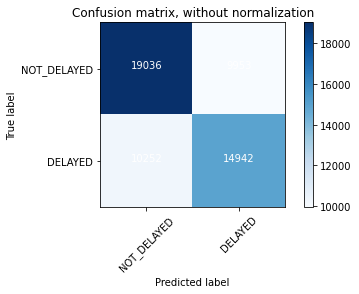

In [50]:
# confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= class_names_list, title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix


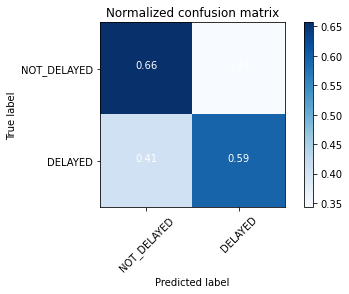

In [51]:
# normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names_list, normalize=True, title='Normalized confusion matrix')
plt.show()

In [52]:
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.372903
